# Using Insitu Data with FluxEngine #

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
# Install basemap-data-hires

In [2]:
# Load data file
region_data = pd.read_csv('CarrickRoads.tsv', sep='\t', index_col=0)
# Show small proportion of the data
region_data.head(5)

,Lon,Lat,Datetime,Year,Month,Day,Hour,Minute,Second,SST_C,windspeed,wind_moment2,air_pressure,salinity,xCO2air,fCO2
0,-5.020000,50.120000,2013-09-03 10:00:00,2013,9,3,10,0,0,15.719004,9.979101,99.582466,1016.816978,29.996252,411.999158,396.333024
1,-5.020620,50.120390,2013-09-03 10:06:40,2013,9,3,10,18,26,15.131422,10.312441,106.346443,1018.016526,29.998362,411.999655,398.415692
2,-5.021239,50.120781,2013-09-03 10:12:34,2013,9,3,10,39,42,16.355280,10.527172,110.821342,1016.255779,30.012203,412.000009,395.321205
3,-5.021855,50.121175,2013-09-03 10:16:32,2013,9,3,11,6,50,15.825956,10.461178,109.436249,1019.006612,30.008640,412.001285,396.234702
4,-5.022468,50.121573,2013-09-03 10:18:04,2013,9,3,11,20,24,15.417900,9.553928,91.277539,1018.660670,29.989048,411.998671,399.337084


In [3]:
# Initialise the new Dataframe column and fill with a hold value
region_data['Hours_since'] = 'hold value'

# Produce a datetime object for the first recording 
# - the zeros in the line below show it's the first row (index starts at zero)
start_date = dt.datetime(region_data.loc[0,'Year'],region_data.loc[0,'Month'],region_data.loc[0,'Day'],
                            region_data.loc[0,'Hour'],region_data.loc[0,'Minute'],region_data.loc[0,'Second'])

# Loop over all rows in the Dataframe - i.e from 0 to the length of the Dataframe
for i in range(0,len(region_data)):
    # Get the date time object for the currently indexed recording - indexed by i
    future_date = dt.datetime(region_data.loc[i,'Year'],region_data.loc[i,'Month'],region_data.loc[i,'Day'],
                              region_data.loc[i,'Hour'],region_data.loc[i,'Minute'],region_data.loc[i,'Second'])
    
    # Find difference between current datetime and inital datetime
    day_diff = future_date - start_date
    
    # Fill Dataframe column with time difference in seconds (found using .total_seconds()) 
    # divided by 86400 (proportion of days that have passed)
    region_data.loc[i,'Hours_since'] = day_diff.total_seconds()/(60*60)

In [4]:
# Filter data to 'Datetime' and 'Days_since' columns and show first 5 rows.
region_data[['Datetime', 'Hours_since']].head(5)

,Datetime,Hours_since
0,2013-09-03 10:00:00,0.0
1,2013-09-03 10:06:40,0.307222
2,2013-09-03 10:12:34,0.661667
3,2013-09-03 10:16:32,1.113889
4,2013-09-03 10:18:04,1.34


In [5]:
# Get min and max of longitude and latitude
region_data.describe().loc[['min','max'],['Lon','Lat']]

,Lon,Lat
min,-5.05,50.12
max,-5.02,50.19


In [6]:
def get_coords(location):
    if location == 'CarrickRoads':
        lon_min = -5.2
        lon_max = -4.9
        lat_min = 50.1
        lat_max = 50.25
        return lon_min, lon_max, lat_min, lat_max
    
    elif location == 'Agulhas':
        lon_min = 19.7
        lon_max = 20.2
        lat_min = -35.0
        lat_max = -34.7
        return lon_min, lon_max, lat_min, lat_max
    
    else:
        lon_min = input('Enter minimum longitude (most Westerly): ')
        lon_max = input('Enter minimum longitude (most Easterly): ')
        lat_min = input('Enter minimum latitude (most Southerly): ')
        lat_max = input('Enter maximum latitude (most Northerly): ')
        print('\n\n')
        if (lon_min >= lon_max) or (lat_min >= lat_max):
            print('Check if min/max were entered in the correct order (is a min greater than a max?)')
            return np.nan, np.nan, np.nan, np.nan
        
        
        return float(lon_min), float(lon_max), float(lat_min), float(lat_max)

In [7]:
### Change string to 'CarrickRoads', 'Agulhas' or your own region name (use '_' for spaces)
region_name = 'CarrickRoads'
# Performs function
lon_min, lon_max, lat_min, lat_max = get_coords(region_name)

# Note: if you're having problems with the input fields you can uncomment the line below 
# and  just enter the values instead, but also comment out the line above to avoid confusion.

# lon_min, lon_max, lat_min, lat_max = __ , __ , __ , __

# Print out current values
print('Current values:')
print(f'Longitude -> \t min:{lon_min} \t max:{lon_max}')
print(f'Latitude -> \t min:{lat_min} \t max:{lat_max}')

Current values:
Longitude -> 	 min:-5.2 	 max:-4.9
Latitude -> 	 min:50.1 	 max:50.25


In [8]:
split_lon = round((lon_max - lon_min)/0.05) + 1
lons = np.linspace(lon_min,lon_max,split_lon)

split_lat = round((lat_max - lat_min)/0.05) + 1
lats = np.linspace(lat_min,lat_max,split_lat)

### Adding Satelite Sea Surface Sub-skin Temperature
To use FluxEngine we need the sea surface sub-skin temperature, which can be aquired in daily resolution from the ESA CCI datasets (found here: https://resources.marine.copernicus.eu/product-detail/SST_GLO_SST_L4_REP_OBSERVATIONS_010_024/INFORMATION). Under the 'Data Access' tab there are two options 'ESACCI-GLO-SST-L4-REP-OBS-SST' which covers 1981-2016, and 'C3S-GLO-SST-L4-REP-OBS-SST' for 2017 onwards. By far the easiest way to download the data is using FTP (File Transfer Protocol) which opens the file folders remotely on your PC. Some browsers (particularlly Safari on MacOS) don't allow FTP, but this can be worked around by using a different browser, such as Firefox. You should be able to connect using the 'guest' option when it prompts you, but if you can't try creating an account with the CMEMS (https://resources.marine.copernicus.eu/registration-form) and using your login at the prompt.

The resolution of the ESA CCI data is 0.05x0.05, which results in 25,920,000 data points where most are not needed. You can use the entire dataset with FluxEngine, but it takes a long time to run and also presents problems viewing the data in Panoply. Therefore the following section of code allows us to view only the data in our desired region, and then we can manually fill this in to our dataframe. 

Below we first read the netCDF SST file (you can subsitute the file string with your own downloaded ESA CCI SST data when needed)

In [9]:
sst_ds = Dataset('20130903120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR2.0-v02.0-fv01.0.nc')

Now we want to find the SST values just within region we are interested (i.e the region plotted above). The code below takes our min/max longitudes and latitudes and finds where their array position is in the ESA CCI SST data. 

Indexes:
Rows: 795 -> 798
Cols: 3496 -> 3502
Data slice used: [795:798,3496:3502]


<AxesSubplot:>

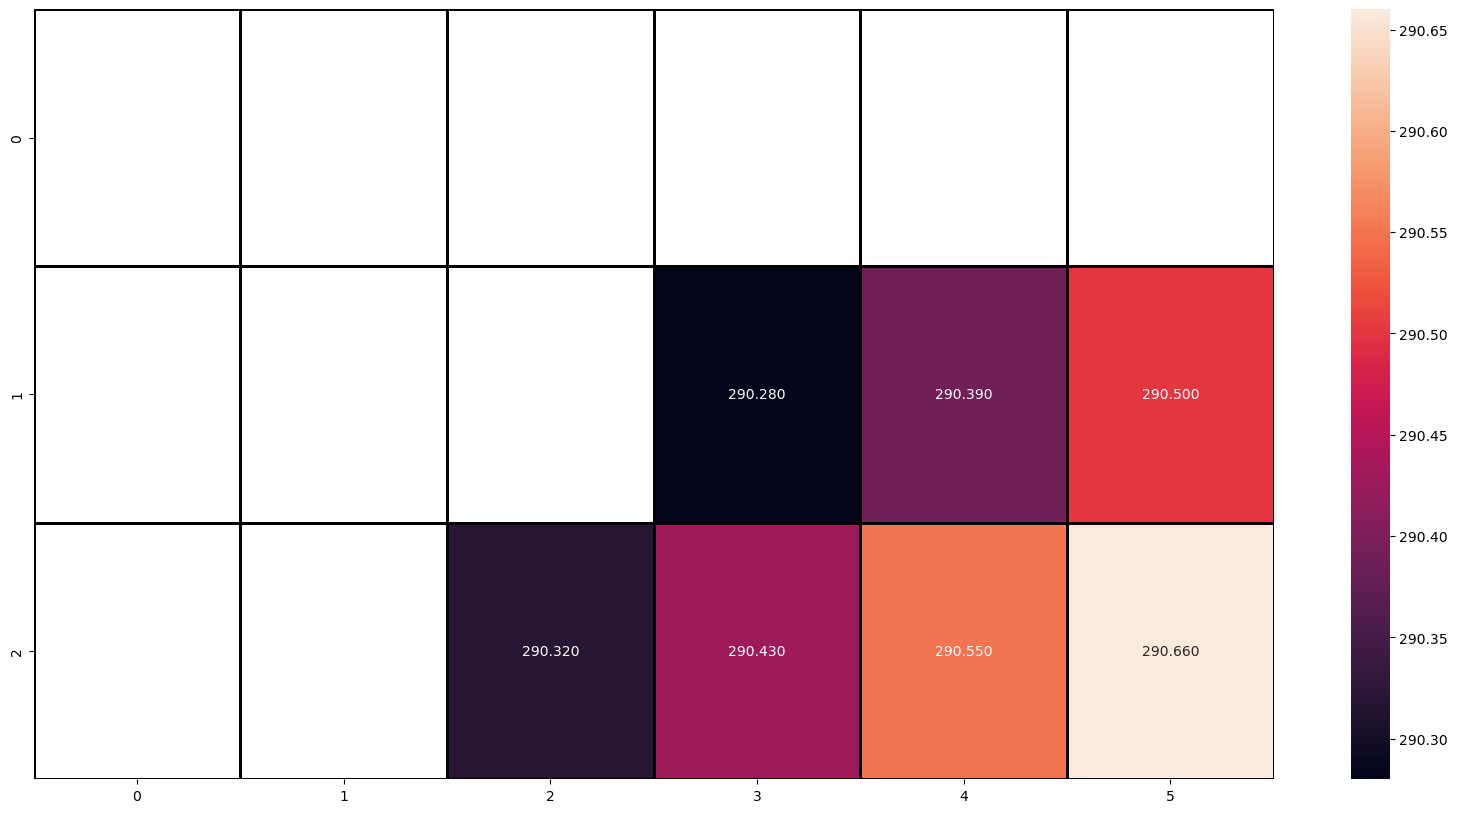

In [10]:
# Finding SST array index for min/max longitude
lon_min_idx = round((lon_min+180)/0.05)
lon_max_idx = round((lon_max+180)/0.05)

# Finding SST array index for min/max latitude
lat_max_idx = round(-(lat_max-90)/0.05)
lat_min_idx = round(-(lat_min-90)/0.05)

# Print the results
print('Indexes:')
print(f'Rows: {lat_max_idx} -> {lat_min_idx}')
print(f'Cols: {lon_min_idx} -> {lon_max_idx}')
print(f'Data slice used: [{lat_max_idx}:{lat_min_idx},{lon_min_idx}:{lon_max_idx}]')

# Get ESA SST values by removing the mask - fill land areas with NaN values
sst_grid = np.ma.filled(sst_ds.variables['analysed_sst'][:],fill_value=np.nan)
sst_grid = np.squeeze(sst_grid) # Reduces data to 2 dimensions
sst_grid = np.flip(sst_grid, axis=0) # Flip data (ESA grid is 'upside down')
# Reduce data to desired region using the indexes found above
region_sst_grid = sst_grid[lat_max_idx:lat_min_idx,lon_min_idx:lon_max_idx]

# Plot the region SST data and annotate values (note: annotation not advised for large data sets)
plt.figure(figsize=(20,10))
sns.heatmap(region_sst_grid,annot=True,fmt=".3f",linewidths=1,linecolor='black')

In order to not calculate fluxes for the entire globe we need to add the ESA SST data into our region dataset. This can be done prgrammatically or using software like Excel. The big problem with using Excel is that when you import your data as a spreadsheet, Excel will change the format of the datetime column - but we need it as yyyy-mm-dd hh:mm:ss for use with FluxEngine - and then we have to go through the convoluted (but possible) process of changing the format back. Instead there is some code below which extracts the array position of the recorded data, matches this to the region SST grid, and fills in the values for you. This code can be complex to write initially, but will likely save time and effort in the long run. Try running the code below using the example datasets, and then test your own.

First we edit our region dataframe to include the 'ESA_SST' column and fill it with a holding value.

In [11]:
# Add ESA_SST column and fill with 'hold value'
region_data['ESA_SST'] = 'hold value'
# Display small section of dataframe
region_data[['Datetime','ESA_SST']].head(5)

,Datetime,ESA_SST
0,2013-09-03 10:00:00,hold value
1,2013-09-03 10:06:40,hold value
2,2013-09-03 10:12:34,hold value
3,2013-09-03 10:16:32,hold value
4,2013-09-03 10:18:04,hold value


In [12]:
# Flip the order of the latitudes (matches latitude index with SST array index)
flip_lats = np.flip(lats,axis=0)

# Loop over rows in region dataframe
for r,row in enumerate(region_data.iterrows()):
    lat = row[1]['Lat'] # Get latitude in row
    lon = row[1]['Lon'] # Get longitude in row
    
    # Loop over increasing longitude values
    # When our 'lon' is less than the longitude we are looping over we know the array index
    for lx in range(1,len(lons),1):
        if lon < lons[lx]:
            break # Breaks out of loop to keep 'lx' = array index
            
    # Loop over increasing latitude values
    # When our 'lat' is less than the latitude we are looping over we know the array index      
    for ly in range(len(flip_lats)-2,-1,-1):
        if lat < flip_lats[ly]:
            break # Breaks out of loop to keep 'ly' = array index
    
    # In the current row we changes the ESA_SST hold value to the correct value in the SST array
    region_data.loc[r,'ESA_SST'] = region_sst_grid[ly,lx-1]

In [13]:
# Visual check of top of data (early in datetime)
region_data[['Lat','Lon','Datetime','ESA_SST']].head(5)

,Lat,Lon,Datetime,ESA_SST
0,50.120000,-5.020000,2013-09-03 10:00:00,290.429993
1,50.120390,-5.020620,2013-09-03 10:06:40,290.429993
2,50.120781,-5.021239,2013-09-03 10:12:34,290.429993
3,50.121175,-5.021855,2013-09-03 10:16:32,290.429993
4,50.121573,-5.022468,2013-09-03 10:18:04,290.429993


In [14]:
# Visual check of bottom of data (late in datetime)
region_data[['Lat','Lon','Datetime','ESA_SST']].tail(5)

,Lat,Lon,Datetime,ESA_SST
95,50.188427,-5.047532,2013-09-03 16:38:44,290.279999
96,50.188825,-5.048145,2013-09-03 16:40:22,290.279999
97,50.189219,-5.048761,2013-09-03 16:45:08,290.279999
98,50.189610,-5.049380,2013-09-03 16:46:30,290.279999
99,50.190000,-5.050000,2013-09-03 16:50:08,290.279999


Finally we need to export our new dataframe as a file to be used in FluxEngine (change the file name to suit the dataset you are using) - be careful NOT to overwrite your orginal data just in case.

In [15]:
# Exports data to a TSV - automatically takes name from the one chosen previously
region_data.to_csv(f'{region_name}_withESASST.tsv', sep='\t')

### Using FluxEngine
Now we have plotted our data we can use FluxEngine to export the data to netCDF files and run FluxEngine (as in tutorial 02).

Note: don't forget the -h label if you need a reminder of how the commands work

Due to how terminal commands are executed this has to be filled out by hand. The commands for the example dataset have been provided (and I suggest looking through all the included commands), but you will need to write your own (or edit the examples) for your own data.

When using the example datasets you will need to change the input file (first string), -ncOutPath, and the --limits commands. When using your own datasets you will need to check all command inputs, and change values where needed.

(Please also check your datetime format as anything except yyyy-mm-dd hh:mm:ss may cause issues - defintely double check the format if you've used Excel at any point).

In [16]:
# Displays values needed for --limit command below
print(f'These are the values for the limit commands -> South:{lat_min}, North:{lat_max}, West:{lon_min}, East:{lon_max}')
print(f'e.g. --limits {lat_min} {lat_max} {lon_min} {lon_max}')

These are the values for the limit commands -> South:50.1, North:50.25, West:-5.2, East:-4.9
e.g. --limits 50.1 50.25 -5.2 -4.9


In [17]:
# We primarily use FluxEngine from the command line, but here we can import it just to check the version
import fluxengine as fe
print(fe.__version__)

4.0


The following cell converts our text file to netCDF for use with FluxEngine.
If changing location to the Agulhas (or your own region) ensure to change the following:
- Text file to read (first argument)
- Coordinates (in order of South, North, West, East) given after --limits
- File name to write out netCDF to given after --ncOutPath
- If using your own data may need to change start and end times too 

In [18]:
# Converting to netCDF
!fe_text2ncdf.py "CarrickRoads_withESASST.tsv" --limits 50.1 50.25 -5.2 -4.9 --ncOutPath "CarrickRoads.nc" --startTime "2013-09-03 00:00:00" --endTime "2013-09-03 23:59:59" --temporalResolution "30 00:00" --cols "SST_C" "windspeed" "wind_moment2" "air_pressure" "salinity" "xCO2air" "fCO2" "ESA_SST" --dateIndex 3 --latProd "Lat" --lonProd "Lon" --latResolution 0.005 --lonResolution 0.005


Parsing command line arguments.
Calculating dimensions.
The following columns will be extracted:
	 SST_C
	 windspeed
	 wind_moment2
	 air_pressure
	 salinity
	 xCO2air
	 fCO2
	 ESA_SST
Processing data in file CarrickRoads_withESASST.tsv
Writing output netCDF file(s)...
Finished converting text file to netCDF3. There were 0 values which fell outside the specified lat/lon or start/stop time boundaries.
Number of missing values found: 0


Here we load the configuration file and tell FluxEngine our start and end dates. Change config file if using a different region, and change dates if required.

In [19]:
# Running FluxEngine
!fe_run.py "CarrickRoads.conf" -s "2013-09-01" -e "2013-09-30" -l


Executing on 'Sayoojs-Air-10.lan' at 22/02/2023 12:30:55
Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (30, 60)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using SSTfnd data selection with correction for skin temperature (SSTskin = SSTfnd - 0.170000)(ignoring SSTskin data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Wanninkhof2014.__call__) Using the Wanninkhof 2014 k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file fe_output/carrickroads/2013/09/carrickroads_fe.nc
Flux engine exited with exit code: 0
01 Sep 2013 00:00:00 completed successfully.



Finally we can merge our FluxEngine output into our text file. Depending on region, you may need to change the first 3 arguments:
- 1st: FluxEngine output file
- 2nd: Text file to merge to
- 3rd: New file to create with merged data

In [20]:
# Appending FluxEngine results
!fe_append2insitu.py "fe_output/carrickroads/2013/09/carrickroads_fe.nc" "CarrickRoads.tsv" "CarrickRoads_merged.tsv" --varsToAppend "OF" "OK3" "OSFC" "OIC1" --dateIndex 3 --lonCol "Lon" --latCol "Lat"


Combining files at  fe_output/carrickroads/2013/09/carrickroads_fe.nc and CarrickRoads.tsv
Row 0 Warning: No data found for timestep 0 lat 50.12 lon -5.02. nan inserted instead
Row 0 Warning: No data found for timestep 0 lat 50.12 lon -5.02. nan inserted instead
Row 0 Warning: No data found for timestep 0 lat 50.12 lon -5.02. nan inserted instead
Row 0 Warning: No data found for timestep 0 lat 50.12 lon -5.02. nan inserted instead
Row 99 Warning: No data found for timestep 0 lat 50.19 lon -5.05. nan inserted instead
Row 99 Warning: No data found for timestep 0 lat 50.19 lon -5.05. nan inserted instead
Row 99 Warning: No data found for timestep 0 lat 50.19 lon -5.05. nan inserted instead
Row 99 Warning: No data found for timestep 0 lat 50.19 lon -5.05. nan inserted instead
Finished merging ['OF', 'OK3', 'OSFC', 'OIC1'] from fe_output/carrickroads/2013/09/carrickroads_fe.nc with CarrickRoads.tsv
Output written to CarrickRoads_merged.tsv


Now we have run FluxEngine and combine our output with our in-situ data, we can go ahead and view/visualise the data.

In [21]:
# Load merged data
merged_data = pd.read_csv('CarrickRoads_merged.tsv', sep='\t',index_col=0).reset_index(drop=True)

In [22]:
# View top of merged data
merged_data.head()

,Lon,Lat,Datetime,Year,Month,Day,Hour,Minute,Second,SST_C,windspeed,wind_moment2,air_pressure,salinity,xCO2air,fCO2,OF [g C m-2 day-1],OK3 [cm h-1],OSFC [g m-3],OIC1 [g m-3]
0,-5.020000,50.120000,2013-09-03 10:00:00,2013,9,3,10,0,0,15.719004,9.979101,99.582466,1016.816978,29.996252,411.999158,396.333024,NaN,NaN,NaN,NaN
1,-5.020620,50.120390,2013-09-03 10:06:40,2013,9,3,10,18,26,15.131422,10.312441,106.346443,1018.016526,29.998362,411.999655,398.415692,0.027161,24.131557,0.181109,0.17642
2,-5.021239,50.120781,2013-09-03 10:12:34,2013,9,3,10,39,42,16.355280,10.527172,110.821342,1016.255779,30.012203,412.000009,395.321205,0.027161,24.131557,0.181109,0.17642
3,-5.021855,50.121175,2013-09-03 10:16:32,2013,9,3,11,6,50,15.825956,10.461178,109.436249,1019.006612,30.008640,412.001285,396.234702,0.027161,24.131557,0.181109,0.17642
4,-5.022468,50.121573,2013-09-03 10:18:04,2013,9,3,11,20,24,15.417900,9.553928,91.277539,1018.660670,29.989048,411.998671,399.337084,0.027161,24.131557,0.181109,0.17642


We need to add out 'Days_since' to this new merged dataframe:

In [23]:
# Initialise the new Dataframe column and fill with a hold value
merged_data['Hours_since'] = 'hold value'

# Produce a datetime object for the first recording 
# - the zeros in the line below show it's the first row (index starts at zero)
start_date = dt.datetime(merged_data.loc[0,'Year'],merged_data.loc[0,'Month'],merged_data.loc[0,'Day'],
                            merged_data.loc[0,'Hour'],merged_data.loc[0,'Minute'],merged_data.loc[0,'Second'])

# Loop over all rows in the Dataframe - i.e from 0 to the length of the Dataframe
for i in range(0,len(merged_data)):
    # Get the date time object for the currently indexed recording - indexed by i
    future_date = dt.datetime(merged_data.loc[i,'Year'],merged_data.loc[i,'Month'],merged_data.loc[i,'Day'],
                              merged_data.loc[i,'Hour'],merged_data.loc[i,'Minute'],merged_data.loc[i,'Second'])
    
    # Find difference between current datetime and inital datetime
    day_diff = future_date - start_date
    
    # Fill Dataframe column with time difference in seconds (found using .total_seconds()) 
    # divided by 86400 (proportion of days that have passed)
    merged_data.loc[i,'Hours_since'] = day_diff.total_seconds()/(60*60)

In [24]:
# Show section of 'Days_since' column for visual check
merged_data[['Datetime', 'Hours_since']].head(5)

,Datetime,Hours_since
0,2013-09-03 10:00:00,0.0
1,2013-09-03 10:06:40,0.307222
2,2013-09-03 10:12:34,0.661667
3,2013-09-03 10:16:32,1.113889
4,2013-09-03 10:18:04,1.34


### Plot the Flux

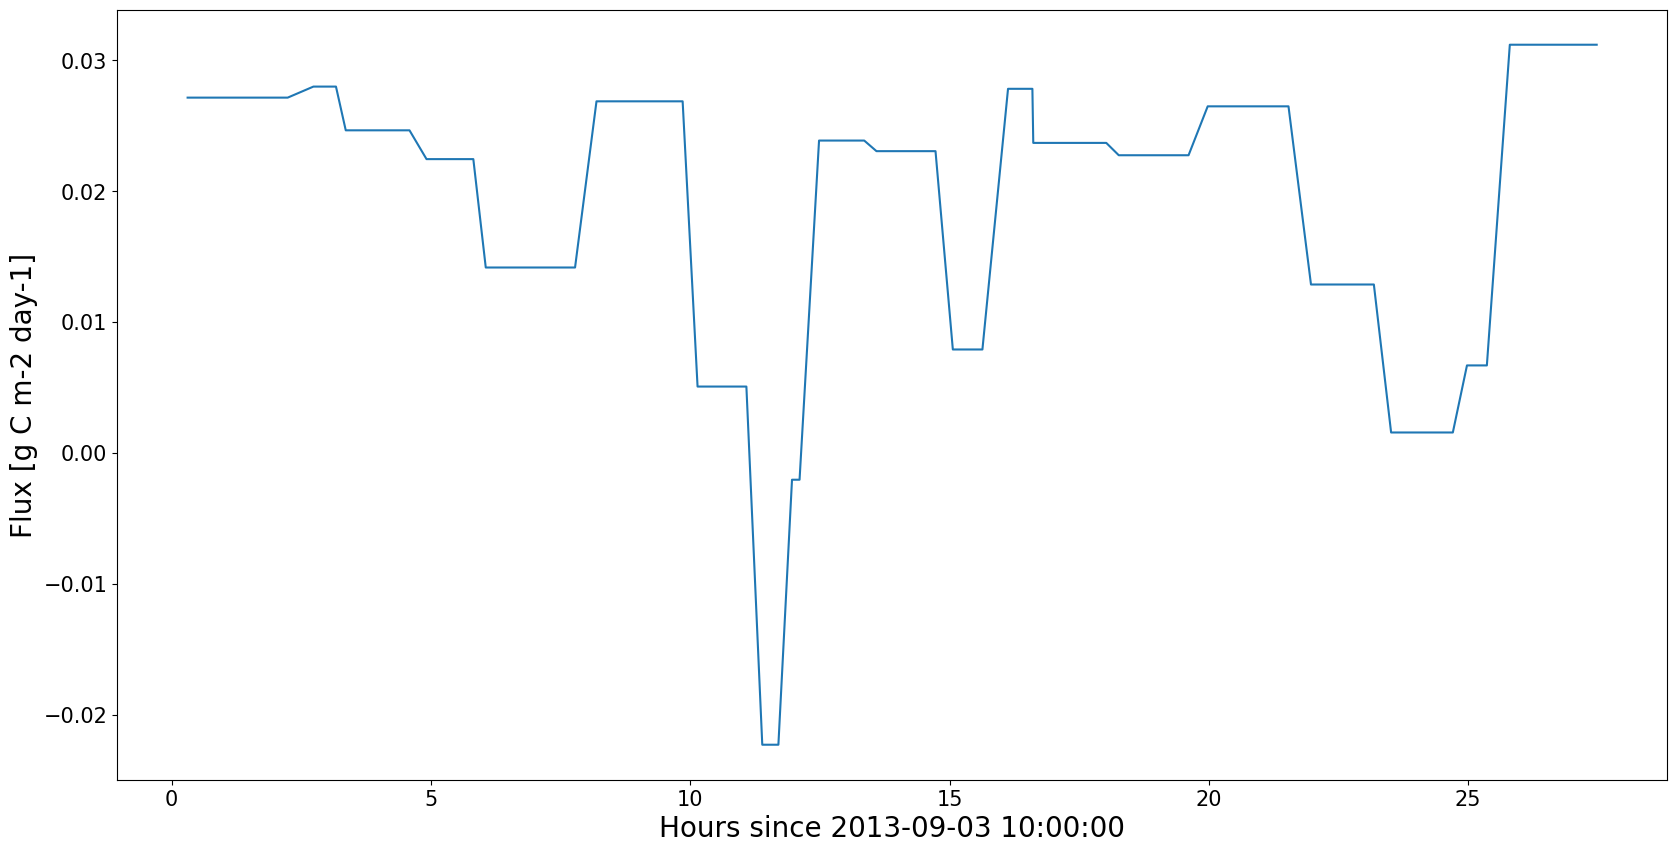

In [25]:
# Set up a figure with 4 axes on it. Sharex=True means all axes will share the bottom axes (can help with clarity)
fig,ax = plt.subplots(1,1, sharex=True, figsize=(20,10))
sns.lineplot(data=merged_data, x='Hours_since', y='OF [g C m-2 day-1]')

# Plot features 
plt.xlabel(f'Hours since {merged_data.loc[0,"Datetime"]}', fontdict={'size':20})
plt.ylabel('Flux [g C m-2 day-1]', fontdict={'size':20})
plt.tick_params(labelsize=15)

# Show figure!
plt.show()